### Búsqueda de imágenes mediante MinHash

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

from os import listdir
from os.path import isfile, join, splitext

from scipy.sparse import csr_matrix

# para reproducibilidad
np.random.seed(2022)



Probaremos nuestro buscador en Oxford Buildings Dataset, el cual consiste de 5062 imágenes de edificios representativos de la ciudad de Oxford. Este conjunto cuenta también con bolsas de características precalculadas de las imágenes con un vocabulario visual de tamaño 1M. Descargamos las imágenes, sus bolsas y una lista de imágenes de consulta con sus correspondientes imágenes relacionadas.


!wget -q https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/word_oxc1_hesaff_sift_16M_1M.tgz
!wget -q https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz
!wget -q https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/gt_files_170407.tgz

!mkdir content/bolsas content/imagenes content/gt
!tar xfz word_oxc1_hesaff_sift_16M_1M.tgz 
!tar xfz oxbuild_images.tgz -C content/imagenes/
!tar xfz gt_files_170407.tgz -C content/gt/

Leemos los nombres de las imágenes de consulta.

In [2]:
rutas_consultas = []
for a in listdir('content/gt/'):
    if 'query.txt' in a:
        with open('content/gt/' + a) as f:
            rutas_consultas.append(f.read().split()[0])

Definimos una función para leer la representación de bolsa de características de los archivos descargados.

In [3]:
def lee_bolsa(ruta):
    b = []
    with open(ruta, 'r') as f:
        for l in f.readlines()[2:]:
            b.append(int(l.split()[0]))
    return b



Recopilamos la lista de imágenes, la dividimos en los subconjuntos base y consulta y cargamos sus bolsas de características.


In [5]:
bolsas_consultas = []
for r in rutas_consultas:
    bolsas_consultas.append(lee_bolsa('./word_oxc1_hesaff_sift_16M_1M/' + r + '.txt'))

rutas_base = [a[:-4] for a in listdir('./word_oxc1_hesaff_sift_16M_1M/')]
bolsas_base = []
for r in rutas_base:
    bolsas_base.append(lee_bolsa('./word_oxc1_hesaff_sift_16M_1M/' + r + '.txt'))

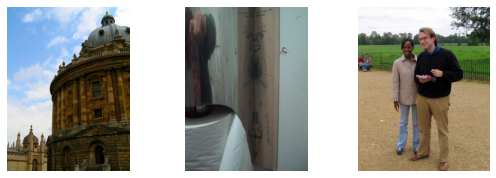

In [6]:
plt.figure(figsize=(10,5))
for k,i in enumerate(rutas_base[1:4]):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('content/imagenes/' + i[5:] + '.jpg')
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()

Visualizamos algunas imágenes del subconjunto consulta.

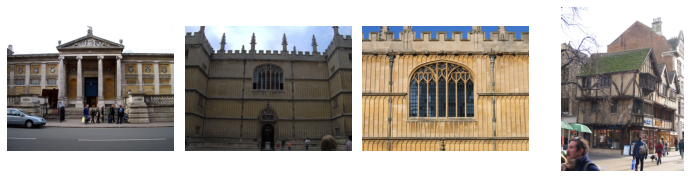

In [8]:
plt.figure(figsize=(10,5))
for k,i in enumerate(rutas_consultas[3:7]):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('content/imagenes/' + i[5:] + '.jpg')
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()



Definimos la clase TablaMinHash, la cual cuenta con los siguientes métodos:

    Insertar: Calcula la tupla de valores MinHash a partir de la representación de bolsa de características de la imágen y guarda su identificador en la cubeta correspondiente
    Buscar: Calcula la tupla de valores MinHash a partir de la representación de bolsa de características de la imágen y regresa la lista de identificadores de imágenes guardada en la cubeta correspondiente.



In [9]:
class TablaMinHash:
    def __init__(self, n_cubetas, t_tupla, dim):
        self.n_cubetas = n_cubetas
        self.tabla = [[] for i in range(n_cubetas)]
        self.dim = dim
        self.t_tupla = t_tupla
        self.perm = np.random.uniform(0, 1, size=(self.dim, self.t_tupla))
        self.rind = np.random.randint(0, np.iinfo(np.int32).max, size=(self.dim, self.t_tupla))
        self.a = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
        self.b = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
        self.primo = 4294967291

    def __repr__(self):
        contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas)]
        return "<TablaHash :%s >" % ('\n'.join(contenido))

    def __str__(self):
        contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas) if self.tabla[i]]
        return '\n'.join(contenido)

    def sl(self, x, i):
        return (self.h(x) + i) % self.n_cubetas

    def h(self, x):
        return x % self.primo

    def minhash(self, x):
        xp = self.perm[np.array(x) - 1]
        xi = self.rind[np.array(x) - 1]
        amin = xp.argmin(axis = 0)
        emin = xi[amin, np.arange(0, self.t_tupla)]

        return np.sum(self.a * emin, dtype=np.ulonglong), np.sum(self.b * emin, dtype=np.ulonglong)
     
    def insertar(self, x, ident):
        mh, v2 = self.minhash(x)

        llena = True
        for i in range(self.n_cubetas):
            cubeta = int(self.sl(v2, i))
            if not self.tabla[cubeta]:
                self.tabla[cubeta].append(mh)
                self.tabla[cubeta].append([ident])
                llena = False
                break
            elif self.tabla[cubeta][0] == mh:
                self.tabla[cubeta][1].append(ident)
                llena = False
                break

        if llena:
            print('¡Error, tabla llena!')

    def buscar(self, x):
        mh, v2 = self.minhash(x)

        for i in range(self.n_cubetas):
            cubeta = int(self.sl(v2, i))
            if not self.tabla[cubeta]:
                return []
            elif self.tabla[cubeta][0] == mh:
                return self.tabla[cubeta][1]
            else:  
                return []

Instancia una lista de tablas MinHash.

In [12]:
n_tablas = 1
dim = 1000000
tablas = [TablaMinHash(2**13, 2, dim) for _ in range(n_tablas)]

Inserta las imágenes del subconjunto base en cada una de las tablas MinHash instanciadas.

In [13]:
for j,l in enumerate(bolsas_base):
    if l:
        for i in range(n_tablas):
            tablas[i].insertar(l, j)

Busca cada una de las imágenes del subconjunto de consutla en todas las tablas MinHash, concatenando la lista de imágenes regresada.

In [14]:
docs = []
for j,l in enumerate(bolsas_consultas):
    dc = []
    if l:
        for i in range(n_tablas):
            dc.extend(tablas[i].buscar(l))
        docs.append(set(dc))

Calcula la similitud de Jaccard entre cada imagen consulta y las imágenes regresadas por las tablas MinHash y las ordena por similitud.

In [15]:
def similitud_jaccard(x, y):
    inter = 0
    for e in x:
        if e in y:
            inter += 1

    return inter / (len(x) + len(y) - inter)

def fuerza_bruta(ds, qs, fd):
    medidas = np.zeros(len(ds))
    for i,x in enumerate(ds):
        medidas[i] = fd(qs, x)

    return np.sort(medidas)[::-1], np.argsort(medidas)[::-1]

sims = []
orden = []
for i,q in enumerate(bolsas_consultas):
    ld = list(docs[i])
    if ld:
        s,o = fuerza_bruta([bolsas_base[k] for k in ld], q, similitud_jaccard)
        sims.append(s)
        orden.append([ld[e] for e in o])
    else:
        sims.append([])
        orden.append([])

Visualizamos una imagen de consulta y las imágenes con mayor similitud.

FileNotFoundError: [Errno 2] No such file or directory: 'content/imagenes/radcliffe_camera_000343.jpg'

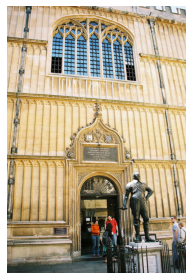

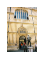

In [16]:
tams = [len(o) for o in orden]
t_max = np.array(tams).argmax()

plt.figure(1)
c = plt.imread('content/imagenes/' + rutas_consultas[t_max][5:] + '.jpg')
plt.imshow(c)
plt.axis('off')
plt.tight_layout()

plt.figure(2)
for i in range(tams[t_max]):
    doc = plt.imread('content/imagenes/' + rutas_base[orden[t_max][i]][5:] + '.jpg')
    plt.subplot(5, 5, i + 1)
    plt.imshow(doc)
    plt.axis('off')
    plt.tight_layout()

plt.show()

Basado en los apuntes del Dr. Gibran Fuentes